In [1]:
import numpy as np
import csv
import pandas as pd

from collections import Counter
from numpy import linalg as LA

In [2]:
with open("/content/drive/MyDrive/CIn/Mestrado/2021.1/Aprendizagem de Máquina/Projeto - Francisco/yeast.data") as input_file:
   lines = input_file.readlines()
   newLines = []
   for line in lines:
      newLine = line.strip().split()
      newLines.append(newLine)

with open("/content/drive/MyDrive/CIn/Mestrado/2021.1/Aprendizagem de Máquina/Projeto - Francisco/yeast.csv", 'w') as test_file:
   file_writer = csv.writer(test_file)
   file_writer.writerows(newLines)

In [3]:
# reading csv files
data =  pd.read_csv("/content/drive/MyDrive/CIn/Mestrado/2021.1/Aprendizagem de Máquina/Projeto - Francisco/yeast.csv",
                    names=["sequence_name", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "protein_local"])
print(data)

     sequence_name   mcg   gvh   alm   mit  erl  pox   vac   nuc protein_local
0       ADT1_YEAST  0.58  0.61  0.47  0.13  0.5  0.0  0.48  0.22           MIT
1       ADT2_YEAST  0.43  0.67  0.48  0.27  0.5  0.0  0.53  0.22           MIT
2       ADT3_YEAST  0.64  0.62  0.49  0.15  0.5  0.0  0.53  0.22           MIT
3       AAR2_YEAST  0.58  0.44  0.57  0.13  0.5  0.0  0.54  0.22           NUC
4       AATM_YEAST  0.42  0.44  0.48  0.54  0.5  0.0  0.48  0.22           MIT
...            ...   ...   ...   ...   ...  ...  ...   ...   ...           ...
1479    YUR1_YEAST  0.81  0.62  0.43  0.17  0.5  0.0  0.53  0.22           ME2
1480    ZIP1_YEAST  0.47  0.43  0.61  0.40  0.5  0.0  0.48  0.47           NUC
1481    ZNRP_YEAST  0.67  0.57  0.36  0.19  0.5  0.0  0.56  0.22           ME2
1482    ZUO1_YEAST  0.43  0.40  0.60  0.16  0.5  0.0  0.53  0.39           NUC
1483    G6PD_YEAST  0.65  0.54  0.54  0.13  0.5  0.0  0.53  0.22           CYT

[1484 rows x 10 columns]


In [4]:
X = data.iloc[:, 1:9].values
y = data.iloc[:, 9].values

In [5]:
def p_estimate_parzen_window(x,h,X,y):

  classes = np.unique(y)

  concat = np.hstack((X,np.expand_dims(y, axis=1)))

  p_list = []

  for i in classes:

    input_values_class = concat[concat[:,-1]==i, 0:-1]

    sub = (x - input_values_class)/h

    cte = (1/(np.sqrt(2)*np.pi))

    K = np.prod(cte*np.exp(-sub.astype(float)**2/2),axis=1)

    p = sum(K)

    n_i = len(sub)

    d = len(sub[0])

    p_list.append([i,p/(n_i*(h**d))])
    
    p = 0

  return p_list

In [6]:
%%time

x = np.array([0.58, 0.61, 0.47, 0.13, 0.5, 0.0, 0.48, 0.22])

h = 1

print(p_estimate_parzen_window(x,h,X,y))

[['CYT', 6.280140660870227e-06], ['ERL', 5.397616926626603e-06], ['EXC', 6.27043511851063e-06], ['ME1', 6.119770598249364e-06], ['ME2', 6.209633611172262e-06], ['ME3', 6.265602948220221e-06], ['MIT', 6.11623159802846e-06], ['NUC', 6.182587409602659e-06], ['POX', 5.432864608999617e-06], ['VAC', 6.347332583367812e-06]]
CPU times: user 5.75 ms, sys: 2.91 ms, total: 8.66 ms
Wall time: 9.55 ms


In [7]:
def probability_priori(y):
  """return a list with each priori probability"""

  pr_pb = Counter(y)

  total = sum(pr_pb.values(), 0.0)

  for key in pr_pb:
    pr_pb[key] /= total  

  return pr_pb

In [8]:
class Parzen:
    def __init__(self, h=1):
        self.h = h

    def predict(self,x,X,y):

      pp = probability_priori(y)

      predict_parzen = []

      for x_i in x:

        parzen = p_estimate_parzen_window(x_i,self.h,X,y)

        parzen_probs = []

        for n,i in enumerate(parzen):
          num = pp[parzen[n][0]]*parzen[n][1]
          den = 0
          for k,j in enumerate(parzen):
            den+= pp[parzen[k][0]]*parzen[k][1]

          parzen_probs.append(num/den)

        predict_parzen.append(parzen[parzen_probs.index(max(parzen_probs))][0])
        #print(parzen_probs)

      return predict_parzen

In [9]:
%%time

a = Parzen(h=0.01)

train_predict = a.predict(X[0:],X,y)

CPU times: user 4.97 s, sys: 0 ns, total: 4.97 s
Wall time: 4.99 s


In [10]:
y_train = data.iloc[:, 9].values

sum([1 for n,i in enumerate(y_train) if train_predict[n] == i])/len(train_predict)

1.0

## item a)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

skf = StratifiedKFold(n_splits=5)
scaler = StandardScaler()
iteration=0

X = data.iloc[:, 1:9].values
Y = data.iloc[:, 9].values

for train_index, test_index in skf.split(X,Y):
        iteration = iteration+1
        X_train, X_test, Y_train, Y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]
        X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2) #actually splitting validation, not test
        
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform (X_test)
        X_validation = scaler.transform (X_validation)
        
        max_acc=0
        max_h=-1

        for h in np.linspace(0.01, 0.3, num=10):

            parzen_alg = Parzen(h=0.1)
            predict_parzen = parzen_alg.predict(X_validation,X_train,Y_train)

            acc = sum([1 for n,i in enumerate(Y_validation) if predict_parzen[n] == i])/len(predict_parzen)

            if (acc>max_acc):
                max_acc=acc
                max_h=h

        print("melhor h:",max_h)
                
        X_train = np.concatenate((X_train, X_validation))
        Y_train = np.concatenate((Y_train, Y_validation))

        parzen_alg = Parzen(h-max_h)
        predict_parzen = parzen_alg.predict(X_test,X_train,Y_train)

        acc = sum([1 for n,i in enumerate(Y_test) if predict_parzen[n] == i])/len(predict_parzen)
        print("Score do parzen:", acc, "")

melhor h: 0.01
Score do parzen: 0.9730639730639731 
melhor h: 0.01
Score do parzen: 0.9797979797979798 
melhor h: 0.01
Score do parzen: 0.9865319865319865 
melhor h: 0.01
Score do parzen: 0.9730639730639731 
melhor h: 0.01
Score do parzen: 0.9662162162162162 


### item b)

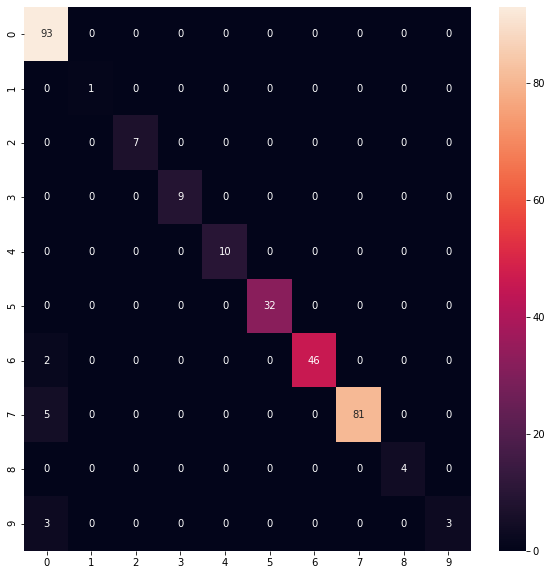

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

cf_matrix = confusion_matrix(Y_test, predict_parzen)

import seaborn as sns

sns.heatmap(cf_matrix, annot=True)

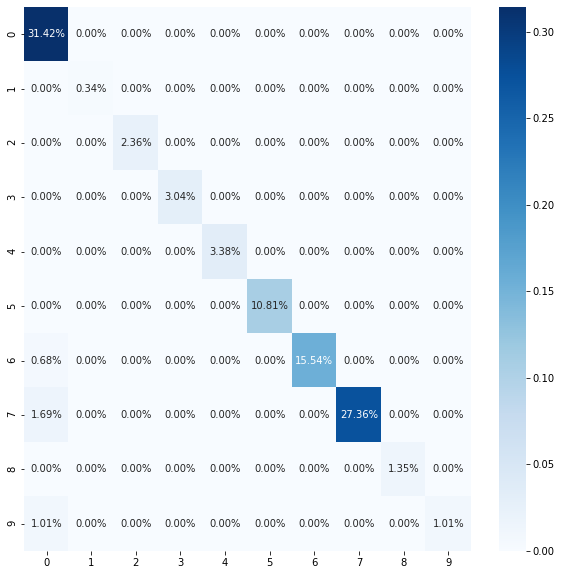

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [16]:
print(classification_report(Y_test,predict_parzen))

              precision    recall  f1-score   support

         CYT       0.90      1.00      0.95        93
         ERL       1.00      1.00      1.00         1
         EXC       1.00      1.00      1.00         7
         ME1       1.00      1.00      1.00         9
         ME2       1.00      1.00      1.00        10
         ME3       1.00      1.00      1.00        32
         MIT       1.00      0.96      0.98        48
         NUC       1.00      0.94      0.97        86
         POX       1.00      1.00      1.00         4
         VAC       1.00      0.50      0.67         6

    accuracy                           0.97       296
   macro avg       0.99      0.94      0.96       296
weighted avg       0.97      0.97      0.97       296

